In [12]:
# Setup path and imports
import sys
sys.path.insert(0, '..')

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
from pathlib import Path
from typing import Dict, List
from collections import Counter

# Stable-Baselines3
from stable_baselines3.common.vec_env import VecNormalize

# Our modules
from src.agents.dqn_agent import DQNAgent
from src.environment.factory import create_envs, sync_eval_env
from src.mdp import ActionSpace

# Plotting style
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (12, 4)

print("✅ Imports successful!")

✅ Imports successful!


## 2. Environment Setup

Create training and evaluation environments using the factory from `src.environment`.

**Key considerations:**
- Use `VecNormalize` for running mean-variance normalization
- Separate seeds for train/eval to avoid overfitting
- Sync normalization statistics between train and eval environments

In [13]:
# Configuration
CONFIG = {
    "train_seed": 42,
    "eval_seed": 123,
    "episode_length": 100,  # Days per episode
    "k": 3,                  # Frame stacking
    "Q_max": 20,             # Max order quantity
    "gamma": 0.99,           # Discount factor (high for inventory)
}

# Create environments
train_env, eval_env = create_envs(**CONFIG)

print("📊 Environment Configuration:")
print(f"  Observation space: {train_env.observation_space.shape} (continuous)")
print(f"  Action space: Discrete({train_env.action_space.n})")
print(f"  Episode length: {CONFIG['episode_length']} days")
print(f"  Frame stacking (k): {CONFIG['k']} → State dim = {(CONFIG['k']+1)*4}")
print(f"  Q_max: {CONFIG['Q_max']} → Actions = {(CONFIG['Q_max']+1)**2}")

📊 Environment Configuration:
  Observation space: (16,) (continuous)
  Action space: Discrete(441)
  Episode length: 100 days
  Frame stacking (k): 3 → State dim = 16
  Q_max: 20 → Actions = 441


## 3. Create and Train DQN Agent

**Hyperparameter choices:**
- `learning_rate`: [1e-5, 1e-3] - use 1e-4 as conservative start
- `gamma`: [0.95, 0.999] - use 0.99 for ~100 day horizon
- `buffer_size`: Large enough for decorrelation
- `exploration_fraction`: 30% of training for ε-decay

In [14]:
# Experiment setup
EXPERIMENT_NAME = f"dqn_{datetime.now().strftime('%Y%m%d_%H%M%S')}"
LOG_DIR = f"./logs/{EXPERIMENT_NAME}"
MODEL_DIR = f"./models/{EXPERIMENT_NAME}"

# Create DQN Agent
agent = DQNAgent(
    env=train_env,
    learning_rate=1e-4,
    gamma=0.99,                    # High gamma for farsighted planning
    buffer_size=100_000,
    batch_size=64,
    exploration_fraction=0.3,      # 30% of training for exploration
    exploration_final_eps=0.05,
    target_update_interval=500,
    learning_starts=1000,
    train_freq=4,
    net_arch=[256, 256],           # Two hidden layers
    tensorboard_log="./logs/dqn_inventory",
    seed=CONFIG["train_seed"],
    verbose=0,
)

print(f"✅ DQN Agent created: {agent}")
print(f"\n📁 Experiment: {EXPERIMENT_NAME}")
print(f"   Logs: {LOG_DIR}")
print(f"   Models: {MODEL_DIR}")

✅ DQN Agent created: DQNAgent(lr=0.0001, γ=0.99, arch=[256, 256], device=auto)

📁 Experiment: dqn_20260107_152753
   Logs: ./logs/dqn_20260107_152753
   Models: ./models/dqn_20260107_152753


## 4. Training

Train the DQN agent with periodic evaluation.

**Monitor with TensorBoard:**
```bash
tensorboard --logdir=./logs
```

In [15]:
# Training parameters
TOTAL_TIMESTEPS = 1_000_000

print(f"🚀 Starting training for {TOTAL_TIMESTEPS:,} timesteps...")
print(f"   ≈ {TOTAL_TIMESTEPS // CONFIG['episode_length']:,} episodes")
print(f"\n💡 Monitor with: tensorboard --logdir=./logs\n")

# Sync normalization before training
sync_eval_env(train_env, eval_env)

# Train the agent
agent.train(
    total_timesteps=TOTAL_TIMESTEPS,
    eval_env=eval_env,
    eval_freq=5000,
    n_eval_episodes=10,
    log_dir=LOG_DIR,
    model_dir=MODEL_DIR,
    progress_bar=True,
)

# Save final model
agent.save(Path(MODEL_DIR))

print(f"\n✅ Training complete!")
print(f"   Model saved to: {MODEL_DIR}")

Output()

🚀 Starting training for 1,000,000 timesteps...
   ≈ 10,000 episodes

💡 Monitor with: tensorboard --logdir=./logs



Eval num_timesteps=5000, episode_reward=-41693.40 +/- 10476.21

Episode length: 100.00 +/- 0.00

New best mean reward!

Eval num_timesteps=10000, episode_reward=-122444.10 +/- 1503.09

Episode length: 100.00 +/- 0.00

Eval num_timesteps=15000, episode_reward=-116344.10 +/- 1411.43

Episode length: 100.00 +/- 0.00

Eval num_timesteps=20000, episode_reward=-122890.30 +/- 1556.80

Episode length: 100.00 +/- 0.00

Eval num_timesteps=25000, episode_reward=-111933.10 +/- 1703.02

Episode length: 100.00 +/- 0.00

Eval num_timesteps=30000, episode_reward=-128725.20 +/- 1901.32

Episode length: 100.00 +/- 0.00

Eval num_timesteps=35000, episode_reward=-145929.50 +/- 1692.20

Episode length: 100.00 +/- 0.00

Eval num_timesteps=40000, episode_reward=-131863.90 +/- 1692.41

Episode length: 100.00 +/- 0.00

Eval num_timesteps=45000, episode_reward=-138645.90 +/- 1022.64

Episode length: 100.00 +/- 0.00

Eval num_timesteps=50000, episode_reward=-137738.20 +/- 1272.16

Episode length: 100.00 +/- 0.00

Eval num_timesteps=55000, episode_reward=-138283.00 +/- 1268.62

Episode length: 100.00 +/- 0.00

Eval num_timesteps=60000, episode_reward=-134411.70 +/- 1355.52

Episode length: 100.00 +/- 0.00

Eval num_timesteps=65000, episode_reward=-139828.70 +/- 834.56

Episode length: 100.00 +/- 0.00

Eval num_timesteps=70000, episode_reward=-143520.40 +/- 1262.01

Episode length: 100.00 +/- 0.00

Eval num_timesteps=75000, episode_reward=-96706.80 +/- 1038.06

Episode length: 100.00 +/- 0.00

Eval num_timesteps=80000, episode_reward=-138358.20 +/- 1619.43

Episode length: 100.00 +/- 0.00

Eval num_timesteps=85000, episode_reward=-143819.10 +/- 1109.14

Episode length: 100.00 +/- 0.00

Eval num_timesteps=90000, episode_reward=-125236.40 +/- 1384.62

Episode length: 100.00 +/- 0.00

Eval num_timesteps=95000, episode_reward=-139469.80 +/- 1219.64

Episode length: 100.00 +/- 0.00

Eval num_timesteps=100000, episode_reward=-139202.10 +/- 792.03

Episode length: 100.00 +/- 0.00

Eval num_timesteps=105000, episode_reward=-142334.80 +/- 1334.00

Episode length: 100.00 +/- 0.00

Eval num_timesteps=110000, episode_reward=-146707.00 +/- 925.29

Episode length: 100.00 +/- 0.00

Eval num_timesteps=115000, episode_reward=-147602.10 +/- 1124.51

Episode length: 100.00 +/- 0.00

Eval num_timesteps=120000, episode_reward=-144785.50 +/- 1412.93

Episode length: 100.00 +/- 0.00

Eval num_timesteps=125000, episode_reward=-147046.10 +/- 896.15

Episode length: 100.00 +/- 0.00

Eval num_timesteps=130000, episode_reward=-146137.30 +/- 1201.65

Episode length: 100.00 +/- 0.00

Eval num_timesteps=135000, episode_reward=-146787.90 +/- 1718.31

Episode length: 100.00 +/- 0.00

Eval num_timesteps=140000, episode_reward=-146102.40 +/- 843.65

Episode length: 100.00 +/- 0.00

Eval num_timesteps=145000, episode_reward=-146175.00 +/- 769.69

Episode length: 100.00 +/- 0.00

Eval num_timesteps=150000, episode_reward=-146509.00 +/- 1408.24

Episode length: 100.00 +/- 0.00

Eval num_timesteps=155000, episode_reward=-146158.10 +/- 1103.92

Episode length: 100.00 +/- 0.00

Eval num_timesteps=160000, episode_reward=-147037.40 +/- 1395.82

Episode length: 100.00 +/- 0.00

Eval num_timesteps=165000, episode_reward=-147063.90 +/- 1117.60

Episode length: 100.00 +/- 0.00

Eval num_timesteps=170000, episode_reward=-146475.20 +/- 932.00

Episode length: 100.00 +/- 0.00

Eval num_timesteps=175000, episode_reward=-147038.90 +/- 1570.76

Episode length: 100.00 +/- 0.00

Eval num_timesteps=180000, episode_reward=-147078.00 +/- 672.67

Episode length: 100.00 +/- 0.00

Eval num_timesteps=185000, episode_reward=-146625.40 +/- 1098.07

Episode length: 100.00 +/- 0.00

Eval num_timesteps=190000, episode_reward=-147312.20 +/- 775.62

Episode length: 100.00 +/- 0.00

Eval num_timesteps=195000, episode_reward=-146434.30 +/- 1137.70

Episode length: 100.00 +/- 0.00

Eval num_timesteps=200000, episode_reward=-146193.50 +/- 1394.46

Episode length: 100.00 +/- 0.00

Eval num_timesteps=205000, episode_reward=-145999.90 +/- 1599.31

Episode length: 100.00 +/- 0.00

Eval num_timesteps=210000, episode_reward=-146807.80 +/- 764.70

Episode length: 100.00 +/- 0.00

Eval num_timesteps=215000, episode_reward=-146574.40 +/- 1293.83

Episode length: 100.00 +/- 0.00

Eval num_timesteps=220000, episode_reward=-147444.30 +/- 1359.35

Episode length: 100.00 +/- 0.00

Eval num_timesteps=225000, episode_reward=-146319.40 +/- 1781.79

Episode length: 100.00 +/- 0.00

Eval num_timesteps=230000, episode_reward=-146876.80 +/- 1552.20

Episode length: 100.00 +/- 0.00

Eval num_timesteps=235000, episode_reward=-147284.30 +/- 1769.62

Episode length: 100.00 +/- 0.00

Eval num_timesteps=240000, episode_reward=-145633.30 +/- 1359.57

Episode length: 100.00 +/- 0.00

Eval num_timesteps=245000, episode_reward=-146743.60 +/- 1687.30

Episode length: 100.00 +/- 0.00

Eval num_timesteps=250000, episode_reward=-146939.10 +/- 1534.04

Episode length: 100.00 +/- 0.00

Eval num_timesteps=255000, episode_reward=-146798.10 +/- 1381.96

Episode length: 100.00 +/- 0.00

Eval num_timesteps=260000, episode_reward=-146095.80 +/- 1212.88

Episode length: 100.00 +/- 0.00

Eval num_timesteps=265000, episode_reward=-146790.10 +/- 1620.42

Episode length: 100.00 +/- 0.00

Eval num_timesteps=270000, episode_reward=-145777.60 +/- 1084.46

Episode length: 100.00 +/- 0.00

Eval num_timesteps=275000, episode_reward=-146338.10 +/- 973.15

Episode length: 100.00 +/- 0.00

Eval num_timesteps=280000, episode_reward=-146029.10 +/- 1195.07

Episode length: 100.00 +/- 0.00

Eval num_timesteps=285000, episode_reward=-146309.80 +/- 1456.69

Episode length: 100.00 +/- 0.00

Eval num_timesteps=290000, episode_reward=-145876.10 +/- 1888.58

Episode length: 100.00 +/- 0.00

Eval num_timesteps=295000, episode_reward=-146836.60 +/- 1685.47

Episode length: 100.00 +/- 0.00

Eval num_timesteps=300000, episode_reward=-147561.60 +/- 1212.95

Episode length: 100.00 +/- 0.00

Eval num_timesteps=305000, episode_reward=-146937.70 +/- 1738.66

Episode length: 100.00 +/- 0.00

Eval num_timesteps=310000, episode_reward=-146107.00 +/- 1749.08

Episode length: 100.00 +/- 0.00

Eval num_timesteps=315000, episode_reward=-145821.40 +/- 1140.20

Episode length: 100.00 +/- 0.00

Eval num_timesteps=320000, episode_reward=-146947.50 +/- 982.53

Episode length: 100.00 +/- 0.00

Eval num_timesteps=325000, episode_reward=-146202.30 +/- 1348.19

Episode length: 100.00 +/- 0.00

Eval num_timesteps=330000, episode_reward=-146337.90 +/- 1110.75

Episode length: 100.00 +/- 0.00

Eval num_timesteps=335000, episode_reward=-146090.10 +/- 1426.85

Episode length: 100.00 +/- 0.00

Eval num_timesteps=340000, episode_reward=-146950.70 +/- 2202.28

Episode length: 100.00 +/- 0.00

Eval num_timesteps=345000, episode_reward=-146766.50 +/- 986.02

Episode length: 100.00 +/- 0.00

Eval num_timesteps=350000, episode_reward=-146528.60 +/- 1807.05

Episode length: 100.00 +/- 0.00

Eval num_timesteps=355000, episode_reward=-146612.50 +/- 1859.55

Episode length: 100.00 +/- 0.00

Eval num_timesteps=360000, episode_reward=-146994.20 +/- 1586.77

Episode length: 100.00 +/- 0.00

Eval num_timesteps=365000, episode_reward=-146725.90 +/- 1538.42

Episode length: 100.00 +/- 0.00

Eval num_timesteps=370000, episode_reward=-146554.90 +/- 737.99

Episode length: 100.00 +/- 0.00

Eval num_timesteps=375000, episode_reward=-146791.00 +/- 1263.62

Episode length: 100.00 +/- 0.00

Eval num_timesteps=380000, episode_reward=-146552.90 +/- 1324.31

Episode length: 100.00 +/- 0.00

Eval num_timesteps=385000, episode_reward=-146326.50 +/- 1463.77

Episode length: 100.00 +/- 0.00

Eval num_timesteps=390000, episode_reward=-145927.50 +/- 1249.32

Episode length: 100.00 +/- 0.00

Eval num_timesteps=395000, episode_reward=-146759.40 +/- 2005.38

Episode length: 100.00 +/- 0.00

Eval num_timesteps=400000, episode_reward=-146974.70 +/- 1962.78

Episode length: 100.00 +/- 0.00

Eval num_timesteps=405000, episode_reward=-147564.30 +/- 974.95

Episode length: 100.00 +/- 0.00

Eval num_timesteps=410000, episode_reward=-147459.00 +/- 1176.15

Episode length: 100.00 +/- 0.00

Eval num_timesteps=415000, episode_reward=-146433.30 +/- 1115.03

Episode length: 100.00 +/- 0.00

Eval num_timesteps=420000, episode_reward=-146625.50 +/- 1038.72

Episode length: 100.00 +/- 0.00

Eval num_timesteps=425000, episode_reward=-145931.30 +/- 1572.34

Episode length: 100.00 +/- 0.00

Eval num_timesteps=430000, episode_reward=-146381.30 +/- 764.42

Episode length: 100.00 +/- 0.00

Eval num_timesteps=435000, episode_reward=-146929.40 +/- 1430.99

Episode length: 100.00 +/- 0.00

Eval num_timesteps=440000, episode_reward=-146830.10 +/- 1275.01

Episode length: 100.00 +/- 0.00

Eval num_timesteps=445000, episode_reward=-146940.40 +/- 1049.90

Episode length: 100.00 +/- 0.00

Eval num_timesteps=450000, episode_reward=-146312.40 +/- 1149.43

Episode length: 100.00 +/- 0.00

Eval num_timesteps=455000, episode_reward=-146855.40 +/- 1423.37

Episode length: 100.00 +/- 0.00

Eval num_timesteps=460000, episode_reward=-146700.60 +/- 1556.12

Episode length: 100.00 +/- 0.00

Eval num_timesteps=465000, episode_reward=-145844.00 +/- 1535.21

Episode length: 100.00 +/- 0.00

Eval num_timesteps=470000, episode_reward=-146612.10 +/- 1869.04

Episode length: 100.00 +/- 0.00

Eval num_timesteps=475000, episode_reward=-146381.90 +/- 1011.43

Episode length: 100.00 +/- 0.00

Eval num_timesteps=480000, episode_reward=-146793.70 +/- 1703.31

Episode length: 100.00 +/- 0.00

Eval num_timesteps=485000, episode_reward=-147193.60 +/- 739.97

Episode length: 100.00 +/- 0.00

Eval num_timesteps=490000, episode_reward=-146509.40 +/- 1404.58

Episode length: 100.00 +/- 0.00

Eval num_timesteps=495000, episode_reward=-147174.30 +/- 1507.96

Episode length: 100.00 +/- 0.00

Eval num_timesteps=500000, episode_reward=-146289.60 +/- 1825.35

Episode length: 100.00 +/- 0.00

Eval num_timesteps=505000, episode_reward=-146814.60 +/- 1347.67

Episode length: 100.00 +/- 0.00

Eval num_timesteps=510000, episode_reward=-146828.00 +/- 1186.45

Episode length: 100.00 +/- 0.00

Eval num_timesteps=515000, episode_reward=-146252.00 +/- 1442.61

Episode length: 100.00 +/- 0.00

Eval num_timesteps=525000, episode_reward=-146713.40 +/- 1824.68

Episode length: 100.00 +/- 0.00

Eval num_timesteps=530000, episode_reward=-147383.20 +/- 1729.03

Episode length: 100.00 +/- 0.00

Eval num_timesteps=535000, episode_reward=-146909.70 +/- 1741.83

Episode length: 100.00 +/- 0.00

Eval num_timesteps=540000, episode_reward=-145705.60 +/- 1364.88

Episode length: 100.00 +/- 0.00

Eval num_timesteps=545000, episode_reward=-146439.00 +/- 1850.24

Episode length: 100.00 +/- 0.00

Eval num_timesteps=550000, episode_reward=-147594.20 +/- 1289.51

Episode length: 100.00 +/- 0.00

Eval num_timesteps=555000, episode_reward=-146928.20 +/- 1158.81

Episode length: 100.00 +/- 0.00

Eval num_timesteps=560000, episode_reward=-146670.10 +/- 961.20

Episode length: 100.00 +/- 0.00

Eval num_timesteps=565000, episode_reward=-146965.60 +/- 1370.06

Episode length: 100.00 +/- 0.00

Eval num_timesteps=570000, episode_reward=-146109.20 +/- 2168.76

Episode length: 100.00 +/- 0.00

Eval num_timesteps=575000, episode_reward=-146148.90 +/- 1672.37

Episode length: 100.00 +/- 0.00

Eval num_timesteps=580000, episode_reward=-146614.20 +/- 1213.56

Episode length: 100.00 +/- 0.00

Eval num_timesteps=585000, episode_reward=-145821.50 +/- 918.68

Episode length: 100.00 +/- 0.00

Eval num_timesteps=590000, episode_reward=-146987.20 +/- 437.23

Episode length: 100.00 +/- 0.00

Eval num_timesteps=595000, episode_reward=-147475.00 +/- 1498.94

Episode length: 100.00 +/- 0.00

Eval num_timesteps=600000, episode_reward=-146666.40 +/- 1034.63

Episode length: 100.00 +/- 0.00

Eval num_timesteps=605000, episode_reward=-146086.50 +/- 1195.37

Episode length: 100.00 +/- 0.00

Eval num_timesteps=610000, episode_reward=-146376.10 +/- 788.55

Episode length: 100.00 +/- 0.00

Eval num_timesteps=620000, episode_reward=-146713.90 +/- 1361.86

Episode length: 100.00 +/- 0.00

Eval num_timesteps=625000, episode_reward=-146791.30 +/- 1039.69

Episode length: 100.00 +/- 0.00

Eval num_timesteps=630000, episode_reward=-146916.50 +/- 1339.75

Episode length: 100.00 +/- 0.00

Eval num_timesteps=635000, episode_reward=-146569.30 +/- 786.98

Episode length: 100.00 +/- 0.00

Eval num_timesteps=640000, episode_reward=-146222.90 +/- 1602.31

Episode length: 100.00 +/- 0.00

Eval num_timesteps=645000, episode_reward=-146039.60 +/- 1135.82

Episode length: 100.00 +/- 0.00

Eval num_timesteps=650000, episode_reward=-145983.80 +/- 1281.63

Episode length: 100.00 +/- 0.00

Eval num_timesteps=655000, episode_reward=-146221.60 +/- 1518.50

Episode length: 100.00 +/- 0.00

Eval num_timesteps=660000, episode_reward=-146623.20 +/- 1628.51

Episode length: 100.00 +/- 0.00

Eval num_timesteps=665000, episode_reward=-146508.10 +/- 747.97

Episode length: 100.00 +/- 0.00

Eval num_timesteps=670000, episode_reward=-146454.40 +/- 1296.59

Episode length: 100.00 +/- 0.00

Eval num_timesteps=675000, episode_reward=-147014.60 +/- 1660.33

Episode length: 100.00 +/- 0.00

Eval num_timesteps=680000, episode_reward=-146632.80 +/- 730.18

Episode length: 100.00 +/- 0.00

Eval num_timesteps=685000, episode_reward=-145996.30 +/- 1652.87

Episode length: 100.00 +/- 0.00

Eval num_timesteps=690000, episode_reward=-146916.00 +/- 1322.56

Episode length: 100.00 +/- 0.00

Eval num_timesteps=695000, episode_reward=-146357.50 +/- 1492.95

Episode length: 100.00 +/- 0.00

Eval num_timesteps=700000, episode_reward=-146180.60 +/- 1101.99

Episode length: 100.00 +/- 0.00

Eval num_timesteps=705000, episode_reward=-146493.50 +/- 1235.92

Episode length: 100.00 +/- 0.00

Eval num_timesteps=710000, episode_reward=-146168.30 +/- 1505.66

Episode length: 100.00 +/- 0.00

Eval num_timesteps=715000, episode_reward=-146464.50 +/- 1281.99

Episode length: 100.00 +/- 0.00

Eval num_timesteps=720000, episode_reward=-146394.40 +/- 1264.39

Episode length: 100.00 +/- 0.00

Eval num_timesteps=725000, episode_reward=-145507.90 +/- 1700.69

Episode length: 100.00 +/- 0.00

Eval num_timesteps=730000, episode_reward=-147161.00 +/- 1664.17

Episode length: 100.00 +/- 0.00

Eval num_timesteps=735000, episode_reward=-146928.60 +/- 1465.87

Episode length: 100.00 +/- 0.00

Eval num_timesteps=740000, episode_reward=-146315.40 +/- 1149.45

Episode length: 100.00 +/- 0.00

Eval num_timesteps=745000, episode_reward=-145985.30 +/- 1200.89

Episode length: 100.00 +/- 0.00

Eval num_timesteps=750000, episode_reward=-146371.80 +/- 844.58

Episode length: 100.00 +/- 0.00

Eval num_timesteps=755000, episode_reward=-146825.20 +/- 1650.54

Episode length: 100.00 +/- 0.00

Eval num_timesteps=760000, episode_reward=-146874.30 +/- 1453.55

Episode length: 100.00 +/- 0.00

Eval num_timesteps=765000, episode_reward=-146710.80 +/- 1304.12

Episode length: 100.00 +/- 0.00

Eval num_timesteps=770000, episode_reward=-147001.20 +/- 1084.90

Episode length: 100.00 +/- 0.00

Eval num_timesteps=775000, episode_reward=-146150.70 +/- 1029.02

Episode length: 100.00 +/- 0.00

Eval num_timesteps=780000, episode_reward=-146146.20 +/- 1789.60

Episode length: 100.00 +/- 0.00

Eval num_timesteps=785000, episode_reward=-147074.20 +/- 1519.85

Episode length: 100.00 +/- 0.00

Eval num_timesteps=790000, episode_reward=-147434.40 +/- 1063.14

Episode length: 100.00 +/- 0.00

Eval num_timesteps=795000, episode_reward=-146953.00 +/- 1696.33

Episode length: 100.00 +/- 0.00

Eval num_timesteps=800000, episode_reward=-145337.10 +/- 1485.63

Episode length: 100.00 +/- 0.00

Eval num_timesteps=805000, episode_reward=-147686.00 +/- 1060.30

Episode length: 100.00 +/- 0.00

Eval num_timesteps=810000, episode_reward=-146336.00 +/- 1660.13

Episode length: 100.00 +/- 0.00

Eval num_timesteps=815000, episode_reward=-146372.30 +/- 1076.89

Episode length: 100.00 +/- 0.00

Eval num_timesteps=820000, episode_reward=-146684.60 +/- 1470.39

Episode length: 100.00 +/- 0.00

Eval num_timesteps=825000, episode_reward=-146542.00 +/- 1613.37

Episode length: 100.00 +/- 0.00

Eval num_timesteps=830000, episode_reward=-146770.00 +/- 1325.07

Episode length: 100.00 +/- 0.00

Eval num_timesteps=835000, episode_reward=-146685.20 +/- 1221.82

Episode length: 100.00 +/- 0.00

Eval num_timesteps=840000, episode_reward=-147245.40 +/- 1506.28

Episode length: 100.00 +/- 0.00

Eval num_timesteps=845000, episode_reward=-146834.60 +/- 1157.11

Episode length: 100.00 +/- 0.00

Eval num_timesteps=850000, episode_reward=-146763.90 +/- 1106.97

Episode length: 100.00 +/- 0.00

Eval num_timesteps=855000, episode_reward=-146567.70 +/- 1147.41

Episode length: 100.00 +/- 0.00

Eval num_timesteps=860000, episode_reward=-147388.20 +/- 860.92

Episode length: 100.00 +/- 0.00

Eval num_timesteps=865000, episode_reward=-146793.00 +/- 1034.63

Episode length: 100.00 +/- 0.00

Eval num_timesteps=870000, episode_reward=-146666.50 +/- 1758.24

Episode length: 100.00 +/- 0.00

Eval num_timesteps=875000, episode_reward=-146118.40 +/- 1106.52

Episode length: 100.00 +/- 0.00

Eval num_timesteps=880000, episode_reward=-147152.30 +/- 991.55

Episode length: 100.00 +/- 0.00

Eval num_timesteps=885000, episode_reward=-147012.10 +/- 1345.28

Episode length: 100.00 +/- 0.00

Eval num_timesteps=890000, episode_reward=-146815.20 +/- 1071.60

Episode length: 100.00 +/- 0.00

Eval num_timesteps=895000, episode_reward=-147024.60 +/- 1518.93

Episode length: 100.00 +/- 0.00

Eval num_timesteps=900000, episode_reward=-146811.10 +/- 1088.33

Episode length: 100.00 +/- 0.00

Eval num_timesteps=905000, episode_reward=-146504.10 +/- 1174.43

Episode length: 100.00 +/- 0.00

Eval num_timesteps=910000, episode_reward=-145797.20 +/- 1354.73

Episode length: 100.00 +/- 0.00

Eval num_timesteps=915000, episode_reward=-146276.80 +/- 1382.58

Episode length: 100.00 +/- 0.00

Eval num_timesteps=920000, episode_reward=-146264.00 +/- 1178.89

Episode length: 100.00 +/- 0.00

Eval num_timesteps=925000, episode_reward=-146725.90 +/- 1603.11

Episode length: 100.00 +/- 0.00

Eval num_timesteps=930000, episode_reward=-146906.70 +/- 1538.24

Episode length: 100.00 +/- 0.00

Eval num_timesteps=935000, episode_reward=-146648.70 +/- 1024.87

Episode length: 100.00 +/- 0.00

Eval num_timesteps=940000, episode_reward=-146568.20 +/- 1361.04

Episode length: 100.00 +/- 0.00

Eval num_timesteps=945000, episode_reward=-146450.90 +/- 1587.03

Episode length: 100.00 +/- 0.00

Eval num_timesteps=950000, episode_reward=-146298.70 +/- 1555.88

Episode length: 100.00 +/- 0.00

Eval num_timesteps=955000, episode_reward=-147074.60 +/- 1524.99

Episode length: 100.00 +/- 0.00

Eval num_timesteps=960000, episode_reward=-146662.10 +/- 1142.29

Episode length: 100.00 +/- 0.00

Eval num_timesteps=965000, episode_reward=-146063.20 +/- 1509.99

Episode length: 100.00 +/- 0.00

Eval num_timesteps=970000, episode_reward=-146155.40 +/- 1318.58

Episode length: 100.00 +/- 0.00

Eval num_timesteps=975000, episode_reward=-146072.20 +/- 1795.88

Episode length: 100.00 +/- 0.00

Eval num_timesteps=980000, episode_reward=-147348.80 +/- 1202.80

Episode length: 100.00 +/- 0.00

Eval num_timesteps=985000, episode_reward=-146870.40 +/- 1342.78

Episode length: 100.00 +/- 0.00

Eval num_timesteps=990000, episode_reward=-146191.70 +/- 1546.22

Episode length: 100.00 +/- 0.00

Eval num_timesteps=995000, episode_reward=-146179.50 +/- 1117.11

Episode length: 100.00 +/- 0.00

Eval num_timesteps=1000000, episode_reward=-147176.80 +/- 1353.26

Episode length: 100.00 +/- 0.00


✅ Training complete!
   Model saved to: ./models/dqn_20260107_152753


## 5. Evaluation & Analysis

**Key metrics to track:**
- Mean reward/cost with confidence intervals
- Service level (% demand satisfied)
- Average inventory level
- Order frequency

In [16]:
def run_evaluation_episode(agent: DQNAgent, env: VecNormalize, action_space: ActionSpace) -> Dict:
    """Run one episode and collect detailed metrics."""
    obs = env.reset()
    
    data = {
        'step': [], 
        'net_inv_0': [], 'net_inv_1': [],
        'outstanding_0': [], 'outstanding_1': [],
        'action': [], 'q0': [], 'q1': [],
        'cost': [], 'reward': [],
        'stockout_0': [], 'stockout_1': [],
    }
    
    done = False
    step = 0
    
    while not done:
        action = agent.select_action(obs, deterministic=True)
        action_obj = action_space.get_action(action)
        
        obs, reward, done, info = env.step([action])
        
        net_inv = info[0]['net_inventory']
        outstanding = info[0]['outstanding']
        cost = info[0]['cost']
        
        data['step'].append(step)
        data['net_inv_0'].append(net_inv[0])
        data['net_inv_1'].append(net_inv[1])
        data['outstanding_0'].append(outstanding[0])
        data['outstanding_1'].append(outstanding[1])
        data['action'].append(action)
        data['q0'].append(action_obj.order_quantities[0])
        data['q1'].append(action_obj.order_quantities[1])
        data['cost'].append(cost)
        data['reward'].append(float(reward[0]))
        data['stockout_0'].append(1 if net_inv[0] < 0 else 0)
        data['stockout_1'].append(1 if net_inv[1] < 0 else 0)
        
        step += 1
        done = done[0]
    
    # Calculate KPIs
    data['kpis'] = {
        'total_cost': sum(data['cost']),
        'avg_daily_cost': np.mean(data['cost']),
        'service_level_0': 1 - np.mean(data['stockout_0']),
        'service_level_1': 1 - np.mean(data['stockout_1']),
        'avg_inventory_0': np.mean([max(0, x) for x in data['net_inv_0']]),
        'avg_inventory_1': np.mean([max(0, x) for x in data['net_inv_1']]),
        'order_frequency_0': np.mean([1 if q > 0 else 0 for q in data['q0']]),
        'order_frequency_1': np.mean([1 if q > 0 else 0 for q in data['q1']]),
        'avg_order_size_0': np.mean([q for q in data['q0'] if q > 0]) if any(data['q0']) else 0,
        'avg_order_size_1': np.mean([q for q in data['q1'] if q > 0]) if any(data['q1']) else 0,
    }
    
    return data


def run_multiple_evaluations(agent: DQNAgent, env: VecNormalize, 
                              action_space: ActionSpace, n_episodes: int = 20) -> Dict:
    """Run multiple episodes and aggregate statistics."""
    all_results = []
    
    for i in range(n_episodes):
        env.env_method('reset', seed=1000 + i)
        result = run_evaluation_episode(agent, env, action_space)
        all_results.append(result)
    
    # Aggregate KPIs
    kpi_names = all_results[0]['kpis'].keys()
    aggregated = {}
    
    for kpi in kpi_names:
        values = [r['kpis'][kpi] for r in all_results]
        aggregated[kpi] = {
            'mean': np.mean(values),
            'std': np.std(values),
            'ci_low': np.percentile(values, 2.5),
            'ci_high': np.percentile(values, 97.5),
        }
    
    return {'episodes': all_results, 'aggregated': aggregated}

print("✅ Evaluation functions defined!")

✅ Evaluation functions defined!


In [17]:
# Sync normalization stats after training
sync_eval_env(train_env, eval_env)

# Run evaluation
action_space = ActionSpace(Q_max=CONFIG['Q_max'])
eval_results = run_multiple_evaluations(agent, eval_env, action_space, n_episodes=20)

# Print KPI summary
print("=" * 60)
print("📊 DQN AGENT EVALUATION (20 episodes)")
print("=" * 60)

for kpi, stats in eval_results['aggregated'].items():
    print(f"\n{kpi}:")
    print(f"  Mean: {stats['mean']:.2f} ± {stats['std']:.2f}")
    print(f"  95% CI: [{stats['ci_low']:.2f}, {stats['ci_high']:.2f}]")

📊 DQN AGENT EVALUATION (20 episodes)

total_cost:
  Mean: 146540.45 ± 1904.38
  95% CI: [142910.35, 149718.42]

avg_daily_cost:
  Mean: 1465.40 ± 19.04
  95% CI: [1429.10, 1497.18]

service_level_0:
  Mean: 0.89 ± 0.05
  95% CI: [0.82, 1.00]

service_level_1:
  Mean: 0.96 ± 0.03
  95% CI: [0.90, 1.00]

avg_inventory_0:
  Mean: 574.58 ± 11.29
  95% CI: [548.74, 591.65]

avg_inventory_1:
  Mean: 749.78 ± 9.70
  95% CI: [734.56, 769.06]

order_frequency_0:
  Mean: 1.00 ± 0.00
  95% CI: [1.00, 1.00]

order_frequency_1:
  Mean: 1.00 ± 0.00
  95% CI: [1.00, 1.00]

avg_order_size_0:
  Mean: 19.00 ± 0.00
  95% CI: [19.00, 19.00]

avg_order_size_1:
  Mean: 20.00 ± 0.00
  95% CI: [20.00, 20.00]


## 6. Visualization: Episode Trajectory

Visualize the agent's behavior over a single episode.

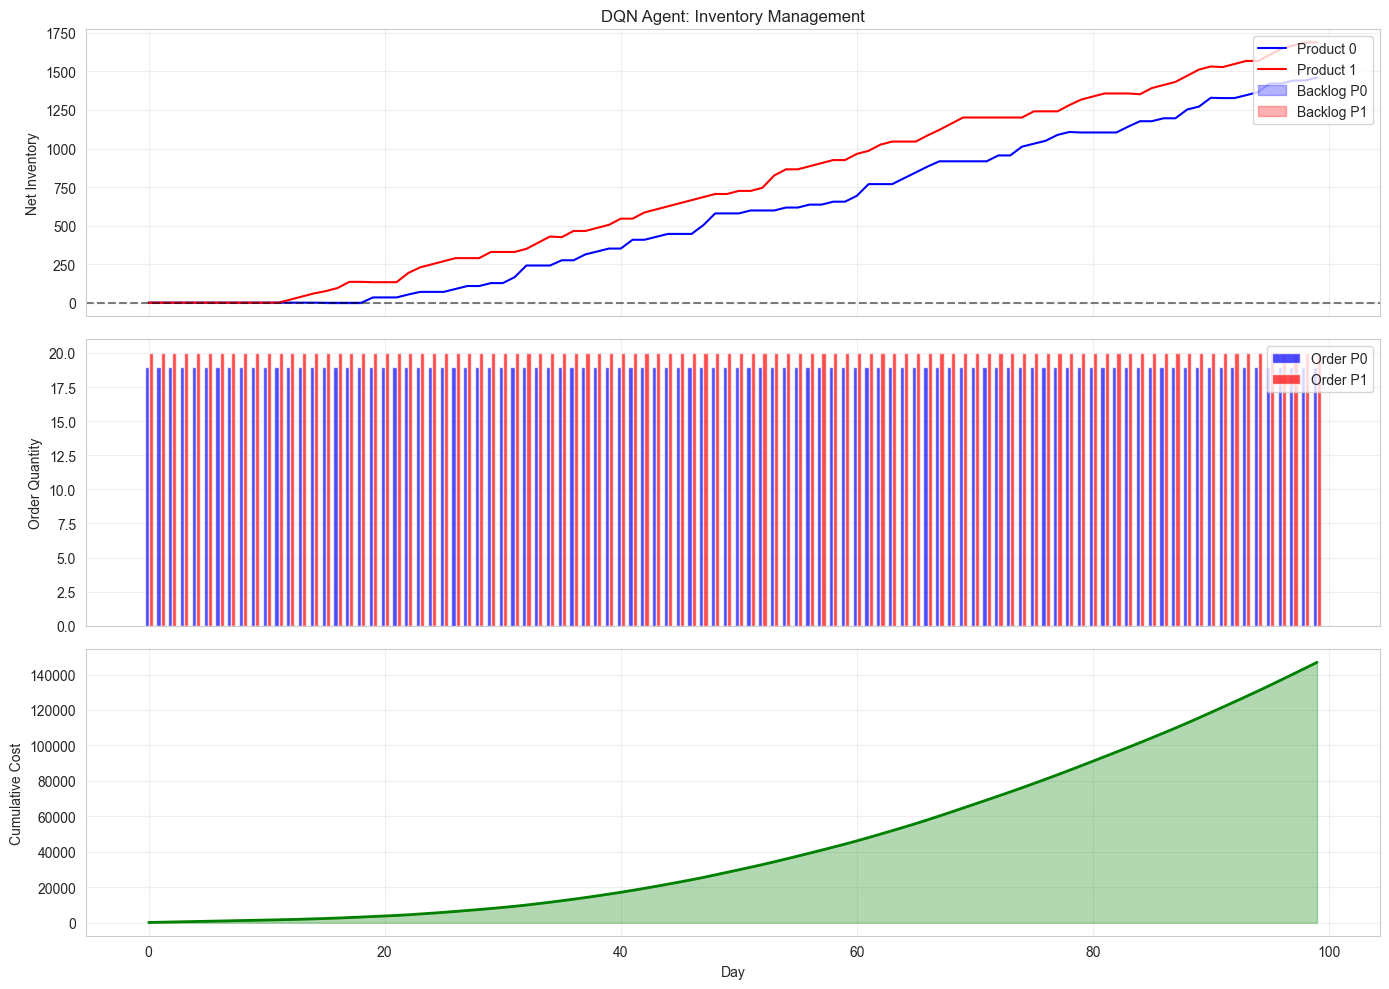


📊 Episode KPIs:
   total_cost: 146888.00
   avg_daily_cost: 1468.88
   service_level_0: 0.96
   service_level_1: 1.00
   avg_inventory_0: 581.67
   avg_inventory_1: 749.93
   order_frequency_0: 1.00
   order_frequency_1: 1.00
   avg_order_size_0: 19.00
   avg_order_size_1: 20.00


In [18]:
def plot_episode_trajectory(episode_data: Dict, title: str = "DQN Agent Episode"):
    """Visualize inventory dynamics over one episode."""
    fig, axes = plt.subplots(3, 1, figsize=(14, 10), sharex=True)
    steps = episode_data['step']
    
    # Plot 1: Inventory Levels
    ax1 = axes[0]
    ax1.plot(steps, episode_data['net_inv_0'], 'b-', label='Product 0', linewidth=1.5)
    ax1.plot(steps, episode_data['net_inv_1'], 'r-', label='Product 1', linewidth=1.5)
    ax1.axhline(y=0, color='k', linestyle='--', alpha=0.5)
    ax1.fill_between(steps, 0, episode_data['net_inv_0'],
                     where=[x < 0 for x in episode_data['net_inv_0']],
                     alpha=0.3, color='blue', label='Backlog P0')
    ax1.fill_between(steps, 0, episode_data['net_inv_1'],
                     where=[x < 0 for x in episode_data['net_inv_1']],
                     alpha=0.3, color='red', label='Backlog P1')
    ax1.set_ylabel('Net Inventory')
    ax1.set_title(title)
    ax1.legend(loc='upper right')
    ax1.grid(True, alpha=0.3)
    
    # Plot 2: Orders Placed
    ax2 = axes[1]
    width = 0.35
    x = np.array(steps)
    ax2.bar(x - width/2, episode_data['q0'], width, label='Order P0', color='blue', alpha=0.7)
    ax2.bar(x + width/2, episode_data['q1'], width, label='Order P1', color='red', alpha=0.7)
    ax2.set_ylabel('Order Quantity')
    ax2.legend()
    ax2.grid(True, alpha=0.3)
    
    # Plot 3: Cumulative Cost
    ax3 = axes[2]
    cumulative_cost = np.cumsum(episode_data['cost'])
    ax3.plot(steps, cumulative_cost, 'g-', linewidth=2)
    ax3.fill_between(steps, 0, cumulative_cost, alpha=0.3, color='green')
    ax3.set_xlabel('Day')
    ax3.set_ylabel('Cumulative Cost')
    ax3.grid(True, alpha=0.3)
    
    plt.tight_layout()
    return fig

# Plot one episode
sample_episode = eval_results['episodes'][0]
fig = plot_episode_trajectory(sample_episode, "DQN Agent: Inventory Management")
plt.savefig(f"{LOG_DIR}/episode_trajectory.png", dpi=150, bbox_inches='tight')
plt.show()

print(f"\n📊 Episode KPIs:")
for k, v in sample_episode['kpis'].items():
    print(f"   {k}: {v:.2f}")

## 7. Visualization: KPI Distributions

Compare KPI distributions across multiple evaluation episodes.

In [ ]:
def plot_kpi_distributions(eval_results: Dict, figsize=(14, 10)):
    """Plot distributions of key performance indicators."""
    episodes = eval_results['episodes']
    
    total_costs = [e['kpis']['total_cost'] for e in episodes]
    service_0 = [e['kpis']['service_level_0'] for e in episodes]
    service_1 = [e['kpis']['service_level_1'] for e in episodes]
    avg_inv_0 = [e['kpis']['avg_inventory_0'] for e in episodes]
    avg_inv_1 = [e['kpis']['avg_inventory_1'] for e in episodes]
    order_freq_0 = [e['kpis']['order_frequency_0'] for e in episodes]
    order_freq_1 = [e['kpis']['order_frequency_1'] for e in episodes]
    
    fig, axes = plt.subplots(2, 3, figsize=figsize)
    
    # Total Cost Distribution
    ax = axes[0, 0]
    ax.hist(total_costs, bins=10, alpha=0.7, color='green', edgecolor='black')
    ax.axvline(np.mean(total_costs), color='red', linestyle='--', label=f'Mean: {np.mean(total_costs):.1f}')
    ax.set_xlabel('Total Episode Cost')
    ax.set_ylabel('Frequency')
    ax.set_title('Cost Distribution')
    ax.legend()
    
    # Service Level P0
    ax = axes[0, 1]
    ax.hist(service_0, bins=10, alpha=0.7, color='blue', edgecolor='black')
    ax.axvline(np.mean(service_0), color='red', linestyle='--', label=f'Mean: {np.mean(service_0):.1%}')
    ax.set_xlabel('Service Level')
    ax.set_title('Service Level - Product 0')
    ax.legend()
    
    # Service Level P1
    ax = axes[0, 2]
    ax.hist(service_1, bins=10, alpha=0.7, color='red', edgecolor='black')
    ax.axvline(np.mean(service_1), color='darkred', linestyle='--', label=f'Mean: {np.mean(service_1):.1%}')
    ax.set_xlabel('Service Level')
    ax.set_title('Service Level - Product 1')
    ax.legend()
    
    # Average Inventory
    ax = axes[1, 0]
    width = 0.35
    x = np.arange(len(episodes))
    ax.bar(x - width/2, avg_inv_0, width, label='Product 0', alpha=0.7)
    ax.bar(x + width/2, avg_inv_1, width, label='Product 1', alpha=0.7)
    ax.set_xlabel('Episode')
    ax.set_ylabel('Avg Inventory')
    ax.set_title('Average Inventory per Episode')
    ax.legend()
    
    # Order Frequency
    ax = axes[1, 1]
    ax.scatter(order_freq_0, order_freq_1, alpha=0.7, s=100)
    ax.set_xlabel('Order Freq P0')
    ax.set_ylabel('Order Freq P1')
    ax.set_title('Order Frequency (P0 vs P1)')
    ax.axhline(0.5, color='gray', linestyle='--', alpha=0.5)
    ax.axvline(0.5, color='gray', linestyle='--', alpha=0.5)
    
    # Cost Metrics
    ax = axes[1, 2]
    kpis = eval_results['aggregated']
    metrics = ['total_cost', 'avg_daily_cost']
    means = [kpis[m]['mean'] for m in metrics]
    stds = [kpis[m]['std'] for m in metrics]
    ax.bar(metrics, means, yerr=stds, capsize=5, alpha=0.7, color=['green', 'orange'])
    ax.set_ylabel('Cost')
    ax.set_title('Cost Metrics (Mean ± Std)')
    
    plt.tight_layout()
    return fig

fig = plot_kpi_distributions(eval_results)
plt.savefig(f"{LOG_DIR}/kpi_distributions.png", dpi=150, bbox_inches='tight')
plt.show()

In [ ]:
def plot_action_analysis(eval_results: Dict, action_space: ActionSpace, figsize=(14, 5)):
    """Analyze action patterns: frequency heatmap and order vs inventory."""
    all_q0, all_q1 = [], []
    all_inv_0, all_inv_1 = [], []
    
    for ep in eval_results['episodes']:
        all_q0.extend(ep['q0'])
        all_q1.extend(ep['q1'])
        all_inv_0.extend(ep['net_inv_0'])
        all_inv_1.extend(ep['net_inv_1'])
    
    fig, axes = plt.subplots(1, 3, figsize=figsize)
    
    # Action frequency heatmap
    ax = axes[0]
    Q_max = action_space.Q_max
    action_matrix = np.zeros((Q_max + 1, Q_max + 1))
    for q0, q1 in zip(all_q0, all_q1):
        action_matrix[q0, q1] += 1
    action_matrix /= action_matrix.sum()
    
    im = ax.imshow(action_matrix, cmap='Blues', origin='lower', aspect='auto')
    ax.set_xlabel('Order Qty P1')
    ax.set_ylabel('Order Qty P0')
    ax.set_title('Action Frequency Heatmap')
    plt.colorbar(im, ax=ax, label='Probability')
    
    # Order vs Inventory (Product 0)
    ax = axes[1]
    ax.scatter(all_inv_0, all_q0, alpha=0.3, s=20)
    ax.axvline(0, color='red', linestyle='--', label='Stockout threshold')
    ax.set_xlabel('Net Inventory P0')
    ax.set_ylabel('Order Quantity P0')
    ax.set_title('Order Decision vs Inventory (P0)')
    ax.legend()
    
    # Order vs Inventory (Product 1)
    ax = axes[2]
    ax.scatter(all_inv_1, all_q1, alpha=0.3, s=20, color='orange')
    ax.axvline(0, color='red', linestyle='--', label='Stockout threshold')
    ax.set_xlabel('Net Inventory P1')
    ax.set_ylabel('Order Quantity P1')
    ax.set_title('Order Decision vs Inventory (P1)')
    ax.legend()
    
    plt.tight_layout()
    return fig

# Plot action analysis
fig = plot_action_analysis(eval_results, action_space)
plt.savefig(f"{LOG_DIR}/action_analysis.png", dpi=150, bbox_inches='tight')
plt.show()

# Print most common actions
all_actions = []
for ep in eval_results['episodes']:
    all_actions.extend(zip(ep['q0'], ep['q1']))

action_counts = Counter(all_actions)
print("\n🎯 Top 10 Most Common Actions (q0, q1):")
for action, count in action_counts.most_common(10):
    pct = count / len(all_actions) * 100
    print(f"   ({action[0]:2d}, {action[1]:2d}): {count:4d} ({pct:.1f}%)")

## 9. Training Curves

Load and visualize training progress from evaluation logs.

In [ ]:
def plot_training_curves(log_dir: str, figsize=(14, 5)):
    """Plot training curves from evaluation logs."""
    eval_path = Path(log_dir) / "evaluations.npz"
    
    if not eval_path.exists():
        print(f"⚠️ No evaluation logs found at {eval_path}")
        return None
    
    data = np.load(eval_path)
    timesteps = data['timesteps']
    results = data['results']
    
    mean_rewards = results.mean(axis=1)
    std_rewards = results.std(axis=1)
    
    fig, axes = plt.subplots(1, 2, figsize=figsize)
    
    # Mean reward over training
    ax = axes[0]
    ax.plot(timesteps, mean_rewards, 'b-', linewidth=2, label='Mean Reward')
    ax.fill_between(timesteps, mean_rewards - std_rewards, mean_rewards + std_rewards, 
                    alpha=0.3, label='±1 Std')
    ax.set_xlabel('Timesteps')
    ax.set_ylabel('Mean Episode Reward')
    ax.set_title('Training Progress: Reward')
    ax.legend()
    ax.grid(True, alpha=0.3)
    
    # Mean cost over training
    ax = axes[1]
    mean_costs = -mean_rewards
    ax.plot(timesteps, mean_costs, 'g-', linewidth=2, label='Mean Cost')
    ax.fill_between(timesteps, mean_costs - std_rewards, mean_costs + std_rewards, 
                    alpha=0.3, color='green', label='±1 Std')
    ax.set_xlabel('Timesteps')
    ax.set_ylabel('Mean Episode Cost')
    ax.set_title('Training Progress: Cost')
    ax.legend()
    ax.grid(True, alpha=0.3)
    
    plt.tight_layout()
    return fig

fig = plot_training_curves(LOG_DIR)
if fig:
    plt.savefig(f"{LOG_DIR}/training_curves.png", dpi=150, bbox_inches='tight')
    plt.show()

## 10. Summary

Final summary of the trained DQN agent.

In [ ]:
# Final Summary
print("=" * 60)
print("📋 DQN AGENT TRAINING SUMMARY")
print("=" * 60)

print(f"\n🔧 Configuration:")
print(f"   Episode length: {CONFIG['episode_length']} days")
print(f"   Frame stacking (k): {CONFIG['k']}")
print(f"   State dimension: {(CONFIG['k']+1) * 4}")
print(f"   Action space: Discrete({(CONFIG['Q_max']+1)**2})")

print(f"\n🎯 Hyperparameters:")
for k, v in agent.hyperparams.items():
    print(f"   {k}: {v}")

print(f"\n📊 Evaluation Results (95% CI):")
kpis = eval_results['aggregated']
print(f"   Total Cost: {kpis['total_cost']['mean']:.1f} [{kpis['total_cost']['ci_low']:.1f}, {kpis['total_cost']['ci_high']:.1f}]")
print(f"   Service Level P0: {kpis['service_level_0']['mean']:.1%}")
print(f"   Service Level P1: {kpis['service_level_1']['mean']:.1%}")
print(f"   Avg Inventory P0: {kpis['avg_inventory_0']['mean']:.1f}")
print(f"   Avg Inventory P1: {kpis['avg_inventory_1']['mean']:.1f}")
print(f"   Order Frequency P0: {kpis['order_frequency_0']['mean']:.1%}")
print(f"   Order Frequency P1: {kpis['order_frequency_1']['mean']:.1%}")

print(f"\n📁 Artifacts:")
print(f"   Model: {MODEL_DIR}/")
print(f"   Logs: {LOG_DIR}/")

print("\n" + "=" * 60)
print("🚀 Next Steps:")
print("   1. Compare with (s,S) baseline policy")
print("   2. Run hyperparameter tuning with Optuna")
print("   3. Try PPO with MultiDiscrete action space")
print("=" * 60)